# Global Features EDA

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

project_root = Path().cwd().parent
sys.path.insert(0, str(project_root))
from src.displayData import inspect_mat_file


Loaded `u1001s0001_sg0001.mat` with scipy.io.loadmat:

Variable `globalFeatures`:
  • type = ndarray
  • shape = (40,)
  • rows = 40, columns = 1
  • dtype = float64
  • No headings stored (raw numeric array)
  • Data:
[0.49795 0.50036 0.49531 0.49521 0.50643 0.49331 0.5019  0.50435 0.5051
 0.50592 0.5013  0.49842 0.50375 0.4946  0.49721 0.49481 0.49683 0.5081
 0.50662 0.50199 0.49881 0.50143 0.50846 0.50128 0.50906 0.49839 0.49701
 0.49255 0.50521 0.50544 0.49574 0.50276 0.50541 0.49614 0.49759 0.50879
 0.49896 0.49794 0.5023  0.50061]
------------------------------------------------------------
Vector length: 40
Mean: 0.50083375


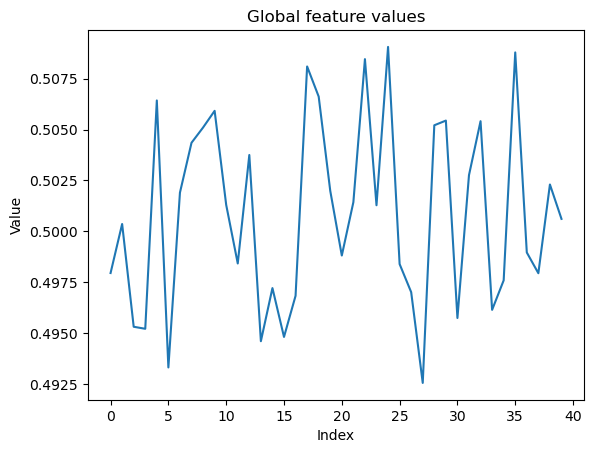

In [2]:
mat_path = project_root / 'tests' / 'testData' / 'GlobalFeatures' / 'u1001s0001_sg0001.mat'
features = inspect_mat_file(mat_path)
vec = features.get('globalFeatures')
if vec is not None:
    print('Vector length:', len(vec))
    print('Mean:', np.mean(vec))
    plt.figure()
    plt.plot(vec)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Global feature values')
    plt.show()
else:
    print('File not found or data missing')
